In [50]:
# Python bibliotekos
import numpy as np                  # "numpy" yra biblioteka darbui su didelėmis, daugiamatėmis masyvų ir matricų kolekcijomis bei matematinėmis funkcijomis
import pandas as pd                 # "pandas" suteikia struktūras duomenims ir įrankius jų analizei, pvz., DataFrame
import matplotlib.pyplot as plt     # "matplotlib.pyplot" yra vizualizacijos biblioteka, leidžianti piešti įvairius grafikus
import warnings                     # "warnings" leidžia valdyti įspėjimus: juos ignoruoti, spausdinti, ar klaidinti
import requests                     # "requests" leidžia siųsti HTTP užklausas naudojant Python
from datetime import datetime       # "datetime" modulis suteikia funkcijas darbui su data ir laiku
from bs4 import BeautifulSoup       # "BeautifulSoup" padeda atlikti internetinių puslapių šaltinio kodo (HTML, XML) analizę ir duomenų surinkimą
import time                         # "time" modulis suteikia funkcijas, susijusias su laiku, pvz., laiko gaišimą ar laiko matavimą
import sqlite3                      # "sqlite3" leidžia dirbti su SQLite duomenų bazėmis, atliekant duomenų saugojimo, atnaujinimo ir gavimo operacijas
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppressing warnings
warnings.filterwarnings('ignore')   # Nustato, kad visi įspėjimai būtų ignoruojami

# Set up Selenium webdriver options
from selenium import webdriver                          # "selenium.webdriver" leidžia automatizuoti veiksmus interneto naršyklėje
from selenium.webdriver.chrome.options import Options   # "Options" leidžia nustatyti konfigūracijas Chrome naršyklės draiveriui

# Papildomai importuojame: 
from sklearn.linear_model import LinearRegression  # Tiesinės regresijos modelis
from sklearn.model_selection import train_test_split  # Duomenų padalijimas į treniravimo ir testavimo rinkinius
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


In [ ]:
# Nuoroda Lietuvos elektros suvartojimui 
# https://data.nordpoolgroup.com/power-system/consumption?deliveryDate=2025-01-09&deliveryAreas=AT&aggregation=DeliveryPeriod

In [62]:
# Surenkame elektros suvartojima is 4 lenteliu 
file_path = 'C:\\Users\\Pauliussl\\Paskaita74\\b2c_ngv_vartojimas.xlsx'
data = pd.read_excel(file_path)
data['dateTime'] = pd.to_datetime(data['dateTime'], errors='coerce')
data['Viso'] = data.iloc[:, 1:].select_dtypes(include='number').sum(axis=1)
data = data[['dateTime', 'Viso']]

file_path2 = 'C:\\Users\\Pauliussl\\Paskaita74\\b2c_gv_vartojimas.xlsx'
data2 = pd.read_excel(file_path2)
data2['dateTime'] = pd.to_datetime(data2['dateTime'], errors='coerce')
data2['Viso1'] = data2.iloc[:, 1:].select_dtypes(include='number').sum(axis=1)
data2 = data2[['dateTime', 'Viso1']]

file_path3 = 'C:\\Users\\Pauliussl\\Paskaita74\\b2b_ngv_vartojimas.xlsx'
data3 = pd.read_excel(file_path3)
data3['dateTime'] = pd.to_datetime(data3['dateTime'], errors='coerce')
data3['Viso2'] = data3.iloc[:, 1:].select_dtypes(include='number').sum(axis=1)
data3 = data3[['dateTime', 'Viso2']]

file_path4 = 'C:\\Users\\Pauliussl\\Paskaita74\\b2b_gv_vartojimas.xlsx'
data4 = pd.read_excel(file_path4)
data4['dateTime'] = pd.to_datetime(data4['dateTime'], errors='coerce')
data4['Viso3'] = data4.iloc[:, 1:].select_dtypes(include='number').sum(axis=1)
data4 = data4[['dateTime', 'Viso3']]

bendra_lentele = pd.merge(left = data2, right= data, left_on= 'dateTime', right_on= 'dateTime', how='inner')
bendra_lentele = pd.merge(left = bendra_lentele, right= data3, left_on= 'dateTime', right_on= 'dateTime', how='inner')
bendra_lentele = pd.merge(left = bendra_lentele, right= data4, left_on= 'dateTime', right_on= 'dateTime', how='inner')


In [64]:
# Sutvarkome elektros suvartojima ir prijungiame oru lentele. 

bendra_lentele['dateTime'] = pd.to_datetime(bendra_lentele['dateTime'], errors='coerce')  # Konvertuojame 'dateTime' stulpelį į datetime formatą, ignoruojant klaidas
bendra_lentele['viso'] = bendra_lentele.iloc[:, 1:].sum(axis=1)                          # Sukuriame naują stulpelį 'viso', kuris yra visų kitų stulpelių suma
bendra_lentele = bendra_lentele.drop(columns=['Viso1', 'Viso2', 'Viso', 'Viso3'], errors='ignore')  # Pašaliname nurodytus stulpelius, ignoruojant klaidas, jei jų nėra
bendra_lentele.head()                                                                    # Peržiūrime pirmas kelias lentelės eilutes

testavimo_lentele = bendra_lentele[bendra_lentele['dateTime'] < '2023-10-30']            # Filtruojame eiles, kuriose 'dateTime' yra mažesnis už 2023-10-30
testavimo_lentele.head()                                                                 # Peržiūrime pirmas kelias testavimo lentelės eilutes

file_path_orai = 'C:\\Users\\Pauliussl\\Paskaita74\\oru_prognoze.csv'                    # Nurodome kelią iki CSV failo su orų duomenimis
data5 = pd.read_csv(file_path_orai)                                                     # Įkeliame CSV failą į duomenų rėmelį 'data5'
data5 = data5.rename(columns={'obs_time_utc':'dateTime'})                               # Pervadiname stulpelį 'obs_time_utc' į 'dateTime'
data5['dateTime'] = pd.to_datetime(data5['dateTime'], errors='coerce')                  # Konvertuojame 'dateTime' stulpelį į datetime formatą, ignoruojant klaidas
data5.head()                                                                            # Peržiūrime pirmas kelias lentelės eilutes

elektra_orai = pd.merge(left=testavimo_lentele, right=data5, left_on='dateTime', right_on='dateTime', how='inner')  # Atliekame sujungimą pagal 'dateTime'
elektra_orai = elektra_orai.drop(columns=['condition_code'], errors='ignore')           # Pašaliname stulpelį 'condition_code', jei jis egzistuoja
elektra_orai.head()                                                                     # Peržiūrime pirmas kelias sujungtos lentelės eilutes



,dateTime,viso,air_temperature,feels_like_temperature,wind_speed,wind_gust,wind_direction,cloud_cover,sea_level_pressure,relative_humidity,precipitation
0,2023-08-01 00:00:00,7528.222124,14.8,14.8,2.1,3.2,165,25.0,1007.7,82,0.0
1,2023-08-01 01:00:00,7300.200090,13.8,13.8,1.5,2.6,150,25.0,1008.0,87,0.0
2,2023-08-01 02:00:00,7114.172580,13.6,13.6,1.7,2.8,142,50.0,1007.6,86,0.0
3,2023-08-01 03:00:00,7025.618630,13.5,13.5,1.3,2.8,146,100.0,1007.5,87,0.0
4,2023-08-01 04:00:00,7298.095296,15.0,15.0,1.6,2.9,142,0.0,1007.0,82,0.0


In [9]:
# Konvertuojame condition code i skaitines reiksmes 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
elektra_orai['condition_code_encoded'] = label_encoder.fit_transform(elektra_orai['condition_code'])
print(elektra_orai[['condition_code', 'condition_code_encoded']].head())


KeyError: 'condition_code'

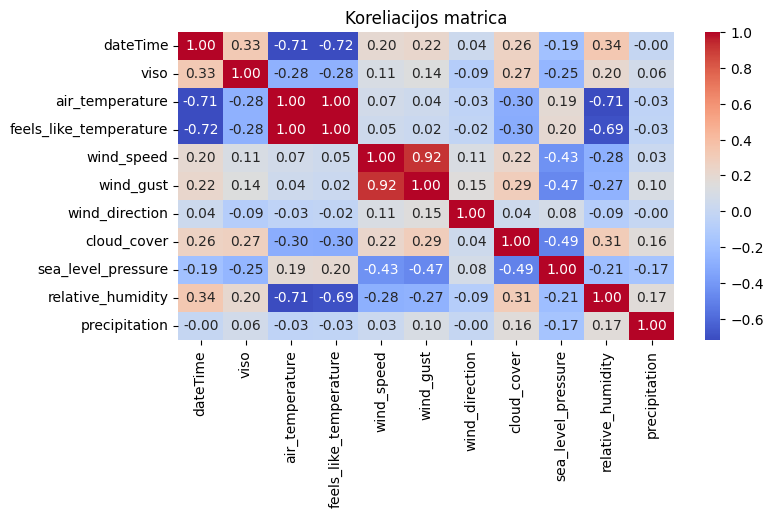

In [65]:
# Nusibrežiame correlation heatmap
correlation_matrix = elektra_orai.corr()                                         # Sukuriame koreliacijos matricą tarp visų stulpelių
correlation_with_viso = correlation_matrix['viso'].sort_values(ascending=False)  # Surikiuojame koreliaciją su 'viso' mažėjančia tvarka

plt.figure(figsize=(8, 4))                                                       # Nustatome grafiko dydį
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")          # Sukuriame koreliacijos šilumos žemėlapį
plt.title("Koreliacijos matrica")                                                # Nustatome grafiko pavadinimą
plt.show()                                                                       # Parodome grafiką


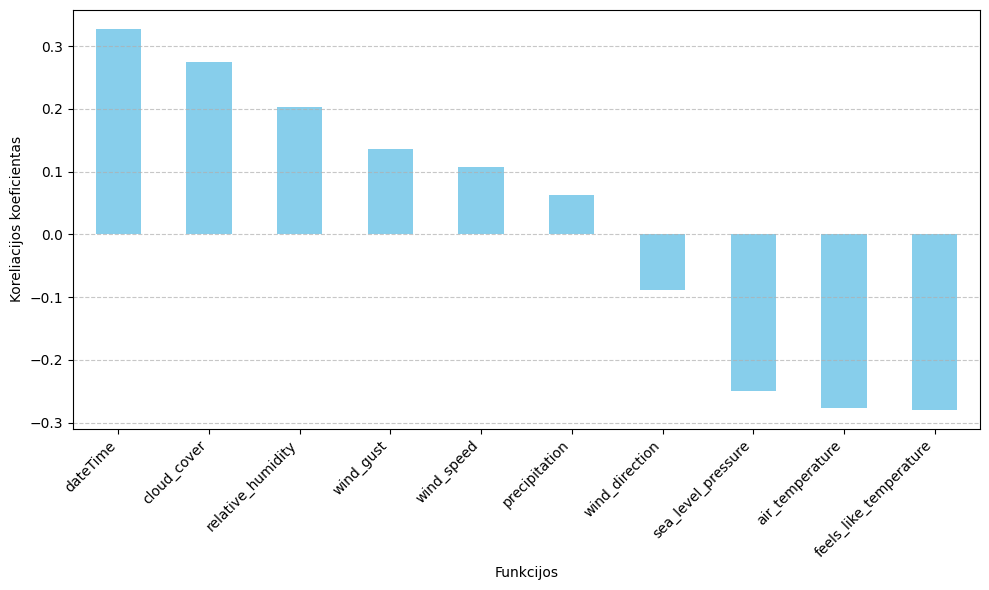

In [66]:
# Nustatome koreliacija su stulpeliu 'viso'
correlation_matrix = elektra_orai.corr()                      # Sukuriame koreliacijos matricą tarp visų stulpelių
correlation_with_viso = correlation_matrix['viso'].sort_values(ascending=False)  # Surikiuojame koreliaciją su 'viso' mažėjančia tvarka

plt.figure(figsize=(10, 6))                                   # Nustatome grafiko dydį
correlation_with_viso.drop('viso').plot(kind='bar', color='skyblue')  # Sukuriame barų diagramą, išskyrus 'viso' stulpelį
plt.ylabel("Koreliacijos koeficientas")                       # Pridedame Y ašies pavadinimą
plt.xlabel("Funkcijos")                                       # Pridedame X ašies pavadinimą
plt.xticks(rotation=45, ha='right')                           # Pasukame X ašies žymes, kad jos būtų geriau matomos
plt.grid(axis='y', linestyle='--', alpha=0.7)                 # Pridedame tinklelius Y ašiai su lengvu stilizavimu
plt.tight_layout()                                            # Automatiškai sutvarkome išdėstymą, kad niekas neperdengtų
plt.show()                                                    # Parodome grafiką

In [68]:
# Paruosiame galutine lentele modeliu apmokinimui
elektra_orai = elektra_orai.drop(columns=['wind_direction', 'precipitation'])
elektra_orai['savaites_diena'] = elektra_orai['dateTime'].dt.weekday
elektra_orai['menesis'] = elektra_orai['dateTime'].dt.month
elektra_orai['valanda'] = elektra_orai['dateTime'].dt.hour
elektra_orai = elektra_orai.drop(columns=['dateTime'])
elektra_orai = elektra_orai.dropna(subset=['cloud_cover'])
elektra_orai

,viso,air_temperature,feels_like_temperature,wind_speed,wind_gust,cloud_cover,sea_level_pressure,relative_humidity,savaites_diena,menesis,valanda
0,7528.222124,14.8,14.8,2.1,3.2,25.0,1007.7,82,1,8,0
1,7300.200090,13.8,13.8,1.5,2.6,25.0,1008.0,87,1,8,1
2,7114.172580,13.6,13.6,1.7,2.8,50.0,1007.6,86,1,8,2
3,7025.618630,13.5,13.5,1.3,2.8,100.0,1007.5,87,1,8,3
4,7298.095296,15.0,15.0,1.6,2.9,0.0,1007.0,82,1,8,4
...,...,...,...,...,...,...,...,...,...,...,...
2155,10682.174280,2.7,-1.3,4.6,9.5,100.0,1007.5,98,6,10,19
2156,10204.631775,4.2,0.0,5.6,10.7,100.0,1006.6,98,6,10,20
2157,9593.699044,5.1,5.1,5.1,10.1,100.0,1005.9,99,6,10,21
2158,9045.732662,6.0,6.0,5.0,10.4,100.0,1005.6,98,6,10,22


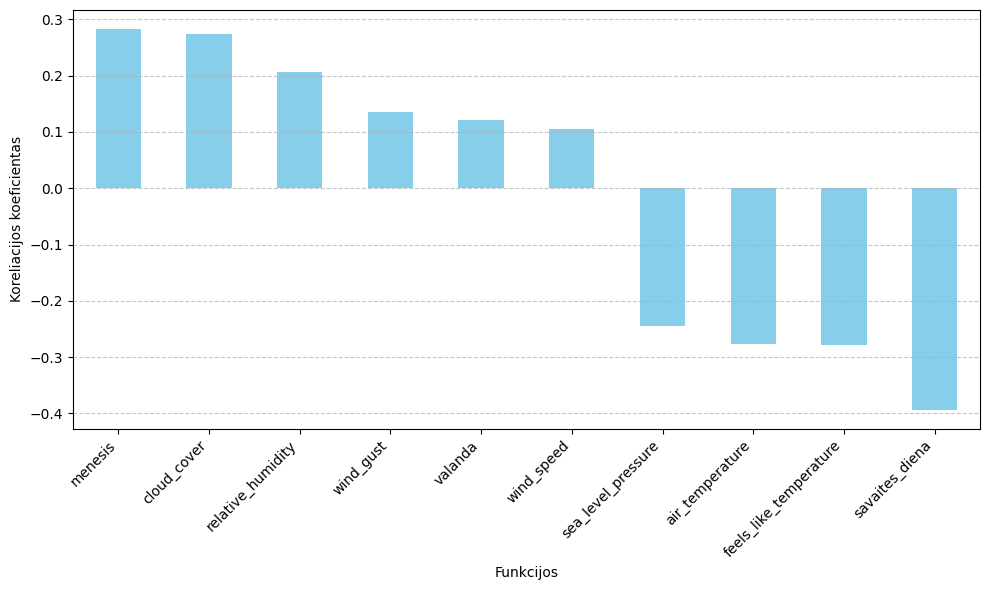

In [69]:
# Nustatome koreliacija su stulpeliu 'viso'
correlation_matrix = elektra_orai.corr()                      # Sukuriame koreliacijos matricą tarp visų stulpelių
correlation_with_viso = correlation_matrix['viso'].sort_values(ascending=False)  # Surikiuojame koreliaciją su 'viso' mažėjančia tvarka

plt.figure(figsize=(10, 6))                                   # Nustatome grafiko dydį
correlation_with_viso.drop('viso').plot(kind='bar', color='skyblue')  # Sukuriame barų diagramą, išskyrus 'viso' stulpelį
plt.ylabel("Koreliacijos koeficientas")                       # Pridedame Y ašies pavadinimą
plt.xlabel("Funkcijos")                                       # Pridedame X ašies pavadinimą
plt.xticks(rotation=45, ha='right')                           # Pasukame X ašies žymes, kad jos būtų geriau matomos
plt.grid(axis='y', linestyle='--', alpha=0.7)                 # Pridedame tinklelius Y ašiai su lengvu stilizavimu
plt.tight_layout()                                            # Automatiškai sutvarkome išdėstymą, kad niekas neperdengtų
plt.show()                                                    # Parodome grafiką

In [75]:
# Modelis: DecisionTreeRegressor 

X = elektra_orai.drop(columns=['viso'])                                         # Pašaliname tikslinį kintamąjį 'viso', paliekant tik nepriklausomus kintamuosius
y = elektra_orai['viso']                                                        # Tikslinis kintamasis yra 'viso'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Padalijame duomenis į mokymo (80%) ir testavimo (20%) rinkinius

model = DecisionTreeRegressor(random_state=42)                                  # Sukuriame sprendimų medžio regresijos modelį su fiksuota random_state reikšme
model.fit(X_train, y_train)                                                     # Apmokome modelį naudojant mokymo duomenis

y_pred = model.predict(X_test)                                                 # Atliekame prognozę testavimo duomenims


In [74]:
# Modelis: LinearRegression

from sklearn.linear_model import LinearRegression

X = elektra_orai.drop(columns=['viso'])                                         # Pašaliname tikslinį kintamąjį 'viso', paliekant tik nepriklausomus kintamuosius
y = elektra_orai['viso']                                                        # Tikslinis kintamasis yra 'viso'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Padalijame duomenis į mokymo (80%) ir testavimo (20%) rinkinius

model = LinearRegression()                                                      # Sukuriame tiesinės regresijos modelį
model.fit(X_train, y_train)                                                     # Apmokome modelį naudojant mokymo duomenis

y_pred = model.predict(X_test)                                                  # Atliekame prognozę testavimo duomenims


In [78]:
# Modelis: RandomForestRegressor 

from sklearn.linear_model import LinearRegression

X = elektra_orai.drop(columns=['viso'])                                         # Pašaliname tikslinį kintamąjį 'viso', paliekant tik nepriklausomus kintamuosius
y = elektra_orai['viso']                                                        # Tikslinis kintamasis yra 'viso'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Padalijame duomenis į mokymo (80%) ir testavimo (20%) rinkinius

model = RandomForestRegressor(n_estimators=100, random_state=42)                                                     # Sukuriame tiesinės regresijos modelį
model.fit(X_train, y_train)                                                     # Apmokome modelį naudojant mokymo duomenis

y_pred = model.predict(X_test)  

